# East coast floods


In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import general_utils
from unseen import indices
from unseen import time_utils
from unseen import spatial_selection

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196001-201601_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196001-201601_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/ks-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_1960-2016_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/ks-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_1960-2016_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196001-201601_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "IPSL-CM6A-LR"
min_lead = 0
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/IPSL-CM6A-LR_dcppA-hindcast_files.txt"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:  (time: 123)
Coordinates:
  * time     (time) object 1900-08-31 00:00:00 ... 2022-08-31 00:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(123,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.74468994140625


## Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s1960-r1i1p1f1_gr_19610101-19701231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/forks/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    spatial_coords=[-40, -20, 140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

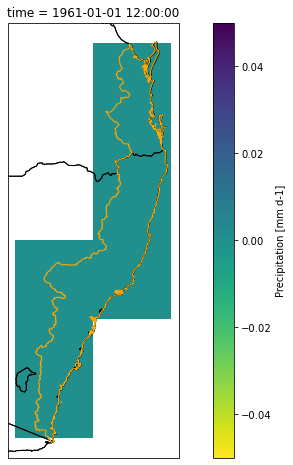

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

## Model ensemble

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 57, lead_time: 11)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) object 1961-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time       (lead_time, init_date) object dask.array<chunksize=(11, 57), meta=np.ndarray>
Data variables:
    pr         (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:       cv=6.2.15.1
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  dcppA-hindcast
    NCO:                    "4.6.0"
    activity_id:            DCPP
    branch_method:          standard
    ...                     ...
    table_id:               day
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / DC...
    tracking_id:            hdl:21.14100/521eb460-8e4b-44d5-8010-e7b978713519
    variable_id:            pr
    variant_info:           Initial conditions are taken from a nudged simula...
    variant_label:          r1i1p1f1

### Independence testing

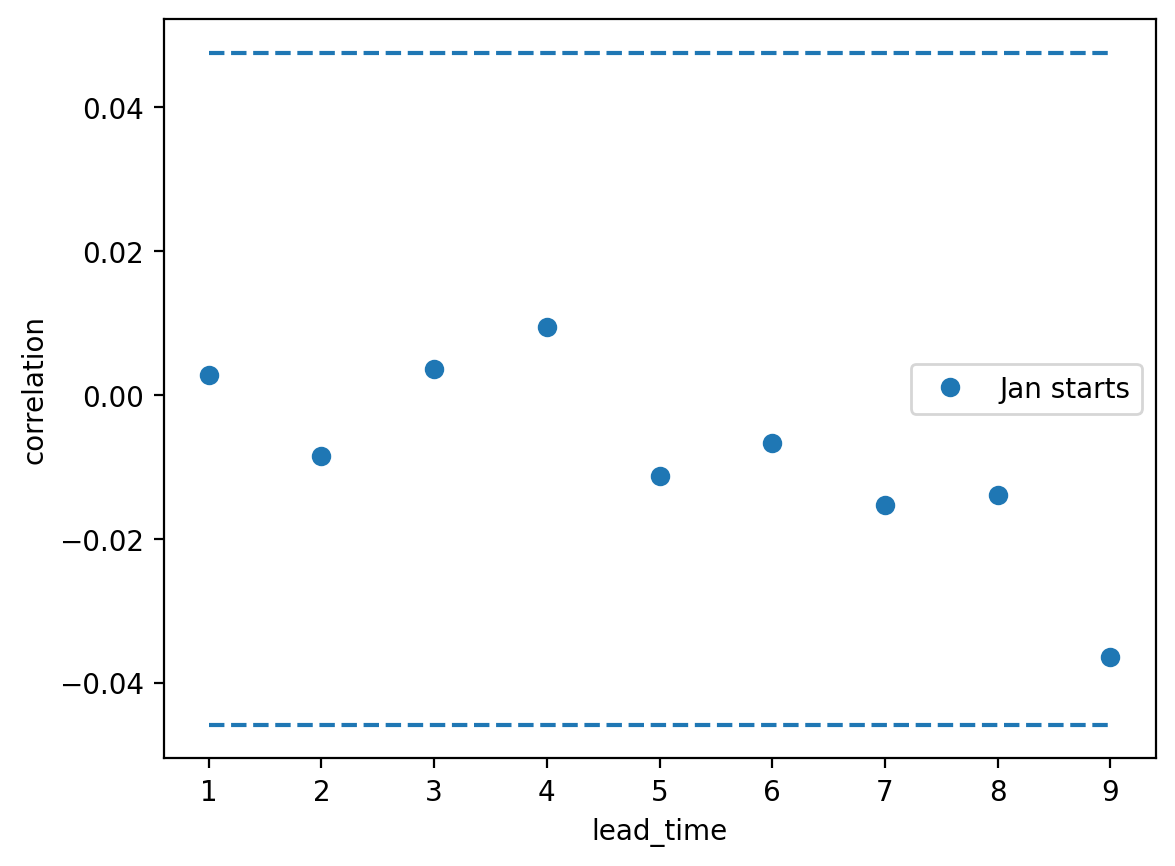

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

0


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

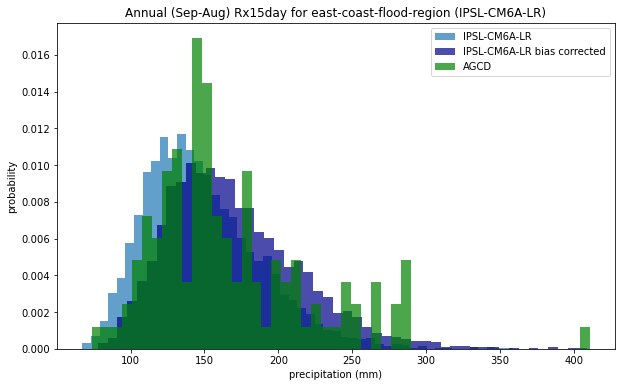

In [20]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
agcd_ds['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [21]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)
similarity_bias_ds['pval'].values

array([0.2941717 , 0.37268704, 0.69116729, 0.40752781, 0.17383846,
       0.16431553, 0.32408117, 0.66986031, 0.42564986])

In [22]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)
similarity_raw_ds['pval'].values

array([0.02061676, 0.01505393, 0.00291568, 0.07436209, 0.10222052,
       0.02403019, 0.11555834, 0.0496637 , 0.0532081 ])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Exceedance curves

In [23]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [24]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period\n')

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [25]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [26]:
model_bc_da_stacked.shape

(5130,)

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_IPSL-CM6A-LR.png


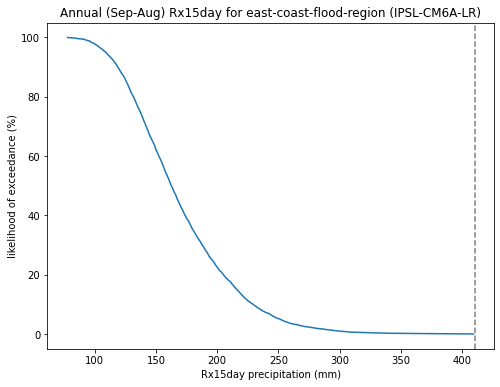

In [27]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [28]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
0 events in 5130 samples
100.00% percentile
inf year return period


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


1960-1969


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 360 samples
100.00% percentile
inf year return period



1970-1979


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 880 samples
100.00% percentile
inf year return period



1980-1989


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period



1990-1999


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 880 samples
100.00% percentile
inf year return period



2000-2009


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period



2010-2019


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 870 samples
100.00% percentile
inf year return period



/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_IPSL-CM6A-LR_by-decade.png


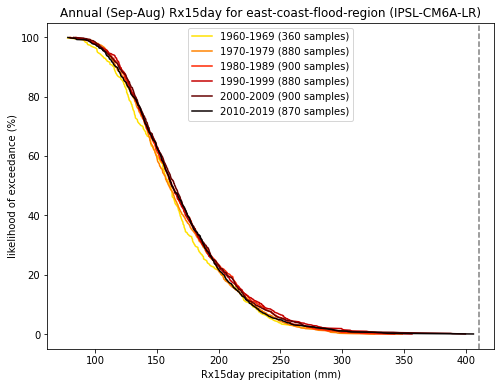

In [29]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

In [30]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [31]:
model_da_stacked.shape

(5130,)

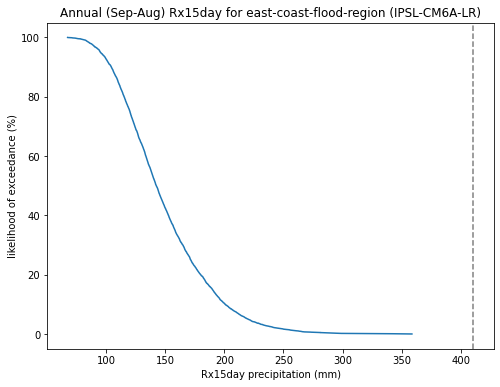

In [32]:
plot_exceedance(model_da_stacked, model_name)

In [33]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 5130 samples
100.00% percentile
inf year return period


/home/599/dbi599/forks/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events
